# Evaluate Model Performance
We want to compare the speed of the model to that of TD-DFT

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from glob import glob
import pickle as pkl
import pandas as pd
import numpy as np
import time
import os
import re

In [2]:
os.environ["OMP_NUM_THREADS"] = "1"

Things to change

In [3]:
traj_path = os.path.join('..', 'datasets', '256_Al', 'Dv1.0')

## Read in Files
We need the random trajectory data, and the trajectory computer

In [4]:
random_traj = pd.read_pickle(os.path.join('data', 'random_data.pkl.gz'))

In [5]:
channel_traj = pd.read_pickle(os.path.join('data', 'channel_data.pkl.gz'))

In [6]:
traj_computer = pkl.load(open('traj_computer.pkl', 'rb'))

## Get the performance of TD-DFT
Get the time per iteration of TD-DFT for the random trajectory

In [7]:
random_traj_files = glob(os.path.join(traj_path, 'kp*.out'))
print('Found {} trajectory files'.format(len(random_traj_files)))

Found 6 trajectory files


Make a function to get the CPU time per iteration

In [8]:
cpu_count_re = re.compile('<mpi_processes count="(.*)"')
assert cpu_count_re.findall('<mpi_processes count="256"') == ['256']

In [9]:
timing_re = re.compile('max="(.*)"')
assert timing_re.findall('max="5"') == ["5"]

In [10]:
def get_iteration_cpu_times(file):
    """Get the CPU time per iteration
    
    Args:
        file (str): path to file to be evaluated
    Returns:
        - ([float]) CPU time per iteration
        - (int) number of cpus"""
    
    with open(file) as fp:
        timings = []
        for line in fp:
            if "<mpi_processes" in line:
                cpu_count = int(cpu_count_re.findall(line)[0])
            if 'timing name="iteration"' in line:
                timings += [float(timing_re.findall(line)[0])]
    
    return np.multiply(timings, cpu_count), cpu_count

Make sure it kind of agrees with the total simulation time (17334s, extracted by hand), which includes the startup cost

In [11]:
timings, cpu_count = get_iteration_cpu_times(os.path.join(traj_path, 'kpgenlong_sd_psd_combo_r17_111_cutoff_50_4.out'))
assert abs(timings.sum() / cpu_count - 17334) / 17334 < 0.10

Get the timings for all steps

In [12]:
%%time
timings = np.hstack([get_iteration_cpu_times(f)[0] for f in random_traj_files])

CPU times: user 926 ms, sys: 89.4 ms, total: 1.02 s
Wall time: 1.02 s


In [13]:
print('Mean time: {:.2f} CPU-hours'.format(timings.mean() / 3600))

Mean time: 2.01 CPU-hours


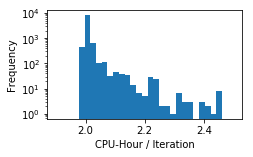

In [14]:
fig, ax = plt.subplots()

ax.hist(timings / 3600, bins=np.linspace(1.9, 2.5, 32))

ax.set_yscale('log')

ax.set_xlabel('CPU-Hour / Iteration')
ax.set_ylabel('Frequency')

fig.set_size_inches(3.5, 2)

*Finding*: The iterations reliably take around 2 CPU-hours each

### Get the Timing for the Channel
The other trajectory for the test

In [15]:
channel_files = glob(os.path.join(traj_path, '..', '..', 'Al_256_channel', 'Dv1.0', 'kp*.out'))
print('Found {} trajectory files'.format(len(channel_files)))

Found 4 trajectory files


In [16]:
%%time
timings = np.hstack([get_iteration_cpu_times(f)[0] for f in channel_files])

CPU times: user 359 ms, sys: 75.5 ms, total: 435 ms
Wall time: 384 ms


In [17]:
print('Average time per iteration: {:.2f} CPU-hrs'.format(np.mean(timings) / 3600))

Average time per iteration: 2.01 CPU-hrs


In [18]:
print('Total number of timesteps:', len(timings))

Total number of timesteps: 2000


In [19]:
channel_hours = np.sum(timings) / 3600
print('Total hours: {:.2f} CPU-hours'.format(channel_hours))

Total hours: 4028.67 CPU-hours


## Time the ML Model
Measure over the channel trajectory

In [20]:
%%time
ml_timings = []
for p, v in channel_traj[['position', 'velocity']].values:
    start = time.perf_counter()
    X = traj_computer.featurizers.featurize(p, v)
    f = traj_computer.model.predict([X])
    stop = time.perf_counter()
    ml_timings.append(stop - start)

CPU times: user 20 s, sys: 18.8 s, total: 38.8 s
Wall time: 12.9 s


Compute the average run time

In [21]:
print('Total ML time: {:.2f} CPU-s'.format(np.sum(ml_timings)))
print('Average ML time: {:.2e} CPU-s, {:.3e} CPU-hr'.format(np.mean(ml_timings), np.mean(ml_timings) / 3600))

Total ML time: 12.93 CPU-s
Average ML time: 6.46e-03 CPU-s, 1.795e-06 CPU-hr


In [22]:
print('ML speedup: {:.2e}x'.format(channel_hours / np.sum(ml_timings) * 3600))

ML speedup: 1.12e+06x


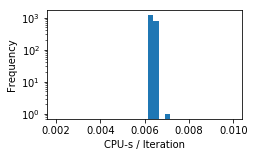

In [23]:
fig, ax = plt.subplots()

ax.hist(ml_timings, bins=np.linspace(0.002, 0.010, 32))

ax.set_yscale('log')

ax.set_xlabel('CPU-s / Iteration')
ax.set_ylabel('Frequency')

fig.set_size_inches(3.5, 2)

*Finding*: ~0.01 CPU-s per iterations is a good estimate (and this is without pipelining)

## Get the time to evaluate the channel
How long does it take, accounting for model without the start-up cost and noise.

Get the minimal length of the channel that must be evaluated

In [24]:
traj_length = np.linalg.norm(traj_computer._compute_trajectory([1, 0, 0]))

In [25]:
print('Minimal length of [100] trajectory:', traj_length)

Minimal length of [100] trajectory: 7.65595


Determine the minimum number of evaluations for evaluating the channel via equal-spaced timesteps

In [26]:
tddft_step_size = (random_traj['displacement'].max() - random_traj['displacement'].min()) / len(random_traj)
print('Step size for the channel trajectory:', tddft_step_size)

Step size for the channel trajectory: 0.014282544226903301


In [27]:
minimum_step_count = int(np.ceil(traj_length / tddft_step_size))
print('Minimum number of steps:', minimum_step_count)

Minimum number of steps: 537


Get the number with adaptive integration

In [28]:
original_force_func = traj_computer._create_force_calculator

In [29]:
global eval_count
eval_count = 0
def tracked_force_func(start_point, lattice_vector, velocity):
    f = original_force_func(start_point, lattice_vector, velocity)
    def wrapped_f(x):
        global eval_count
        eval_count += 1
        return f(x)
    return wrapped_f
traj_computer._create_force_calculator = tracked_force_func

In [30]:
ml_quad_time = time.perf_counter()
traj_computer.compute_stopping_power([0, 0.75, 0.75], [1,0,0], 1)
ml_quad_time = time.perf_counter() - ml_quad_time

In [31]:
print('Adaptive quadrature converges in {} steps, requiring {:.2f} CPU-s'.format(eval_count, ml_quad_time))

Adaptive quadrature converges in 63 steps, requiring 0.40 CPU-s


In [32]:
print('Total speedup of ML: {:.2e}'.format(channel_hours / (ml_quad_time / 3600)))

Total speedup of ML: 3.64e+07
